In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import catboost as cb
%matplotlib inline

# load data sources

In [2]:
train = pd.read_csv("/home/alex/Downloads/kaggle/competition/train.csv")
test = pd.read_csv("/home/alex/Downloads/kaggle/competition/test.csv")
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols


In [3]:
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [4]:
applications_history = pd.read_csv("/home/alex/Downloads/kaggle/competition/applications_history.csv")

print("applications_history.shape = {} rows, {} cols".format(*applications_history.shape))

applications_history.shape = 1670214 rows, 26 cols


In [5]:
applications_history.head(2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [6]:
client_profile = pd.read_csv("/home/alex/Downloads/kaggle/competition/client_profile.csv")

print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))

client_profile.shape = 250000 rows, 24 cols


In [7]:
client_profile.head(2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
bki = pd.read_csv("/home/alex/Downloads/kaggle/competition/bki.csv")

print("bki.shape = {} rows, {} cols".format(*bki.shape))

bki.shape = 945234 rows, 17 cols


In [9]:
payments = pd.read_csv("/home/alex/Downloads/kaggle/competition/payments.csv")

print("payments.shape = {} rows, {} cols".format(*payments.shape))

payments.shape = 1023932 rows, 8 cols


# eda

## applications_history

In [10]:
applications_history.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,4.919130e+07,1.236017e+08,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,3.139511e+02,1.605408e+01,342340.056543,15949.224065,35163.363265,78152.730207,83505.775017,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,7.127443e+03,1.456729e+01,88413.495220,72007.270877,106405.950190,148833.342466,152484.418802,0.471134
min,4.826822e+07,1.234233e+08,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,4.873007e+07,1.235127e+08,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,-1.000000e+00,6.000000e+00,365243.000000,475.000000,257.000000,455.000000,447.000000,0.000000
50%,4.919132e+07,1.236021e+08,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,921.000000,741.000000,1155.000000,1171.000000,0.000000
75%,4.965249e+07,1.236909e+08,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,8.200000e+01,2.400000e+01,365243.000000,1825.000000,1735.000000,2418.000000,2501.000000,1.000000
max,5.011360e+07,1.237796e+08,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [11]:
applications_history.shape

(1670214, 26)

In [12]:
print(applications_history.columns)
print(applications_history.columns.shape)

Index(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE',
       'AMOUNT_ANNUITY', 'AMT_APPLICATION', 'AMOUNT_CREDIT', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'NAME_YIELD_GROUP', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')
(26,)


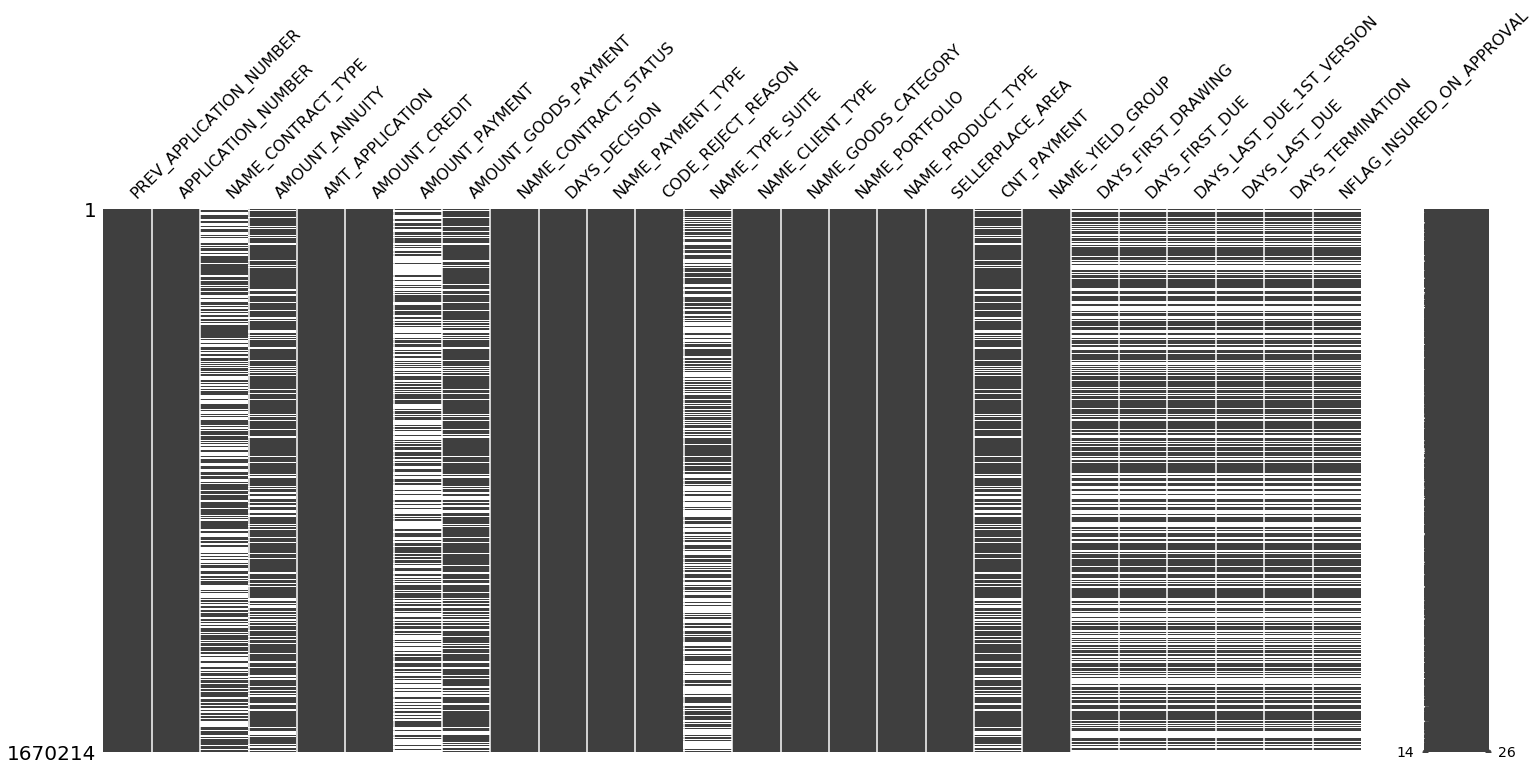

In [13]:
msno.matrix(applications_history)

Данные имеют большое количество пропусков

In [14]:
applications_history_numerical_features = applications_history.select_dtypes(include=[np.number])
print(f"count of applications_history_numeric_features {applications_history_numerical_features.shape[1]}")
applications_history_numerical_features.head(2)

count of applications_history_numeric_features 16


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,1730.430,17145.0,17145.0,0.0,17145.0,73,35,12.0,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,25188.615,607500.0,679671.0,NaN,607500.0,164,-1,36.0,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [15]:
applications_history_categorical_features = applications_history.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {applications_history_categorical_features.shape[1]}")
applications_history_categorical_features.head(2)

Categorical Feature Count 10


,NAME_CONTRACT_TYPE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP
0,NaN,Approved,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,middle
1,Cash,Approved,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,low_action


Данные имеют как числовые так и категориальные фичи. Разберём их подробнее

In [16]:
applications_history_discrete_feature = [
    feature for feature in applications_history_numerical_features
    if len(applications_history[feature].unique())<25
]

print(f"Discrete Variables Count: {len(applications_history_discrete_feature)}")

Discrete Variables Count: 1


In [17]:
applications_history_continuous_feature = [
    feature for feature in applications_history_numerical_features
    if feature not in ["TARGET"] + applications_history_discrete_feature]

print(f"Continuous Feature Count {len(applications_history_continuous_feature)}")

Continuous Feature Count 15


## client_profile

In [18]:
client_profile.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,...,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,...,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,...,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,...,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,...,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,...,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,...,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,...,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [19]:
client_profile.shape

(250000, 24)

In [20]:
print(client_profile.columns)
print(client_profile.columns.shape)

Index(['APPLICATION_NUMBER', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')
(24,)


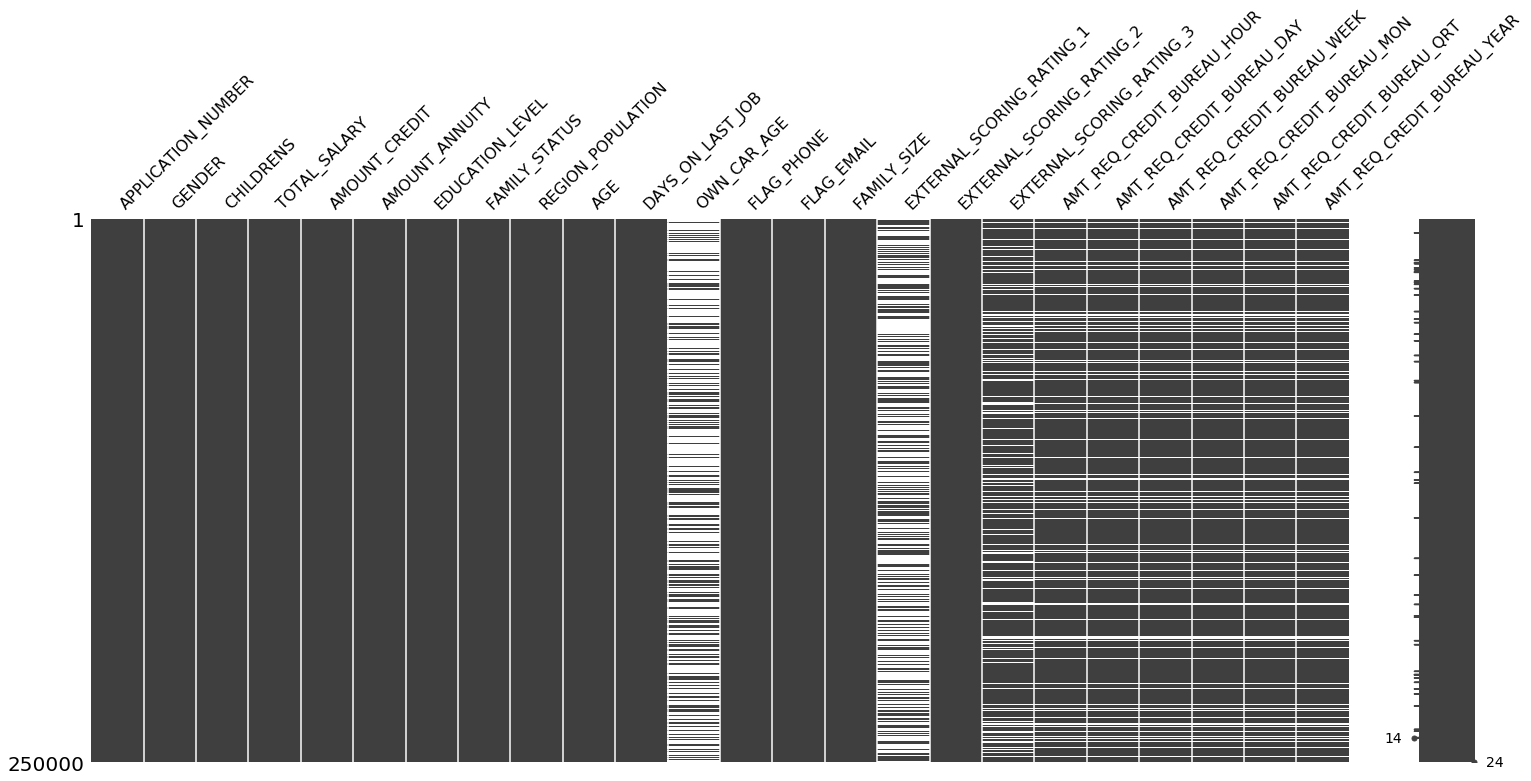

In [21]:
msno.matrix(client_profile)

In [22]:
client_profile_numerical_features = client_profile.select_dtypes(include=[np.number])
print(f"count of client_profile_numeric_features {client_profile_numerical_features.shape[1]}")
client_profile_numerical_features.head(2)

count of client_profile_numeric_features 21


,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,0,157500.0,270000.0,13500.0,0.008068,8560,1549,NaN,1,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,0,270000.0,536917.5,28467.0,0.020246,23187,365243,NaN,0,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [23]:
client_profile_categorical_features = client_profile.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {client_profile_categorical_features.shape[1]}")
client_profile_categorical_features.head(2)

Categorical Feature Count 3


,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
0,F,Incomplete higher,Civil marriage
1,F,Secondary / secondary special,Married


In [24]:
client_profile_discrete_feature = [
    feature for feature in client_profile_numerical_features
    if len(client_profile[feature].unique())<25
]

print(f"Discrete Variables Count: {len(client_profile_discrete_feature)}")

Discrete Variables Count: 8


In [25]:
client_profile_continuous_feature = [
    feature for feature in client_profile_numerical_features
    if feature not in ["TARGET"] + client_profile_discrete_feature]

print(f"Continuous Feature Count {len(client_profile_continuous_feature)}")

Continuous Feature Count 13


## bki

In [26]:
bki.describe()

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,9.452340e+05,9.452340e+05,945234.000000,945234.000000,886797.000000,596274.000000,3.265570e+05,945234.000000,9.452290e+05,8.034830e+05,6.192670e+05,9.452340e+05,945234.000000,2.693300e+05
mean,1.236016e+08,5.974377e+06,1142.218231,0.769791,1819.607174,1018.001196,3.784219e+03,0.006330,3.547738e+05,1.361747e+05,6.267718e+03,3.826128e+01,594.056297,1.646679e+04
std,1.029041e+05,5.330431e+05,795.047305,35.173550,4684.447770,715.013564,2.133823e+05,0.094857,1.078781e+06,6.370282e+05,4.528027e+04,5.156032e+03,721.505604,3.937657e+05
min,1.234233e+08,5.001084e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000,0.000000e+00
25%,1.235122e+08,5.513773e+06,474.000000,0.000000,383.000000,426.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,0.000000e+00,0.000000e+00,33.000000,0.000000e+00
50%,1.236014e+08,5.976502e+06,987.000000,0.000000,863.000000,897.000000,0.000000e+00,0.000000,1.254708e+05,0.000000e+00,0.000000e+00,0.000000e+00,396.000000,0.000000e+00
75%,1.236908e+08,6.435551e+06,1666.000000,0.000000,1504.000000,1489.000000,0.000000e+00,0.000000,3.150000e+05,3.973275e+04,0.000000e+00,0.000000e+00,908.000000,1.350000e+04
max,1.237796e+08,6.942186e+06,2922.000000,2792.000000,42060.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,41943.000000,1.184534e+08


In [27]:
bki.shape

(945234, 17)

In [28]:
print(bki.columns)
print(bki.columns.shape)

Index(['APPLICATION_NUMBER', 'BUREAU_ID', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')
(17,)


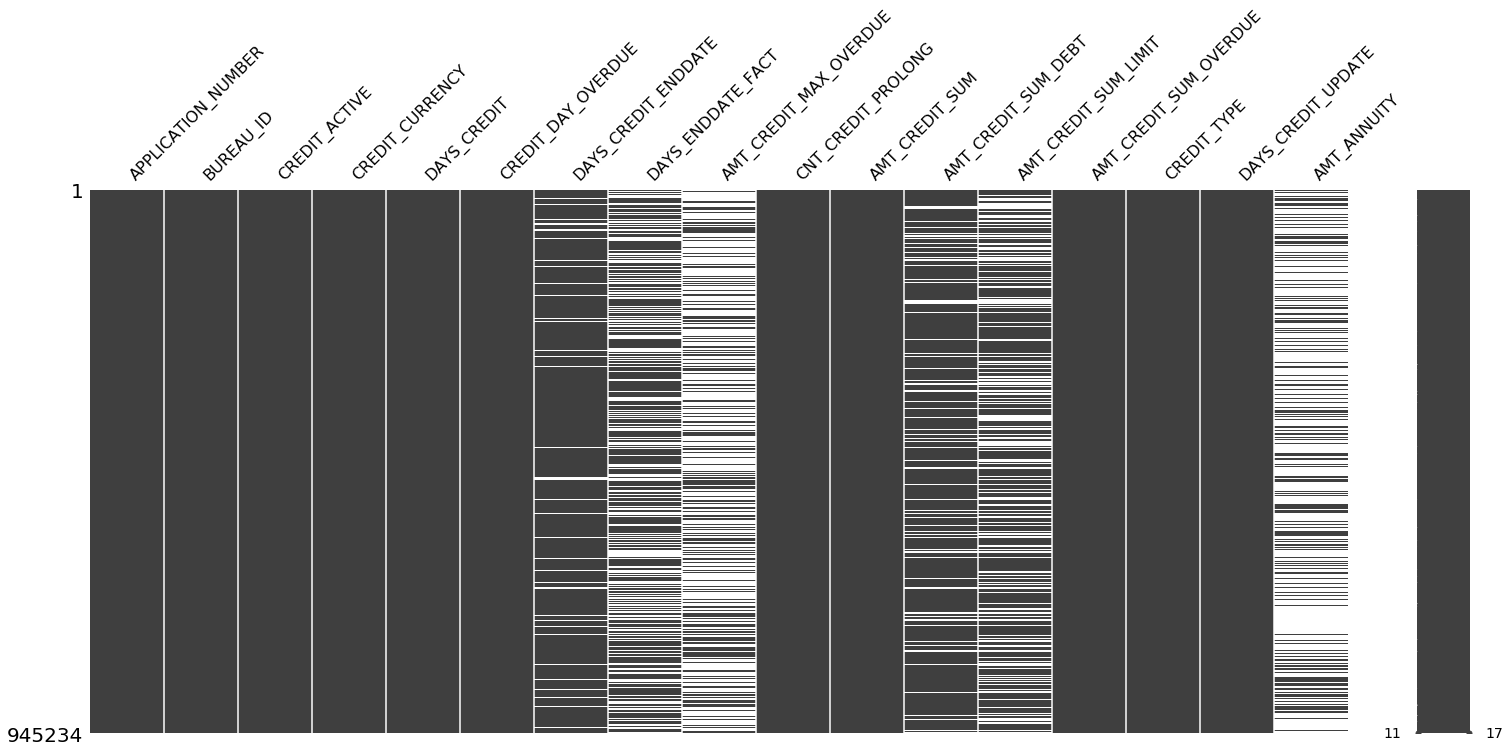

In [29]:
msno.matrix(bki)

In [30]:
bki_numerical_features = bki.select_dtypes(include=[np.number])
print(f"count of bki_numeric_features {bki_numerical_features.shape[1]}")
bki_numerical_features.head(2)

count of bki_numeric_features 14


,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,39.0,NaN
1,123436670,6207544,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,505.0,NaN


In [31]:
bki_categorical_features = bki.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {bki_categorical_features.shape[1]}")
bki_categorical_features.head(2)

Categorical Feature Count 3


,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
0,Active,currency 1,Consumer credit
1,Closed,currency 1,Consumer credit


In [32]:
bki_discrete_feature = [
    feature for feature in bki_numerical_features
    if len(bki[feature].unique())<25
]

print(f"Discrete Variables Count: {len(bki_discrete_feature)}")

Discrete Variables Count: 1


In [33]:
bki_continuous_feature = [
    feature for feature in bki_numerical_features
    if feature not in ["TARGET"] + bki_discrete_feature]

print(f"Continuous Feature Count {len(bki_continuous_feature)}")

Continuous Feature Count 13


# base features

In [34]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [35]:
def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    """
    Построение агрегаций для категориальных признаков.
    Для категориальных признако считаются счетчики для
    каждого значения категории и среднее значение счетчика
    для каждого значения категории.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    features: List[str]
        Список с названием признаков, для которых произвести
        группировку.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

In [36]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
    X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)

    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["EXTERNAL_SCORING_WEIGHTED"] = X.EXTERNAL_SCORING_RATING_1 * 2 + X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['RATIO_CREDIT_TO_ANNUITY'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["RATIO_ANNUITY_TO_SALARY"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['RATIO_CREDIT_TO_SALARY'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    #X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
    X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    # Отношение врменных признаков
    X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]

    return X

In [37]:
applications_history_numerical_features.columns

Index(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER', 'AMOUNT_ANNUITY',
       'AMT_APPLICATION', 'AMOUNT_CREDIT', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [38]:
aggs = {
    "PREV_APPLICATION_NUMBER": ["count"],
    "AMOUNT_ANNUITY": [np.mean, np.std, np.sum, "max"],
    "AMT_APPLICATION": [np.mean, np.std, np.sum, "max"],
    "AMOUNT_CREDIT": [np.mean, np.std, np.sum, "max"],
    "AMOUNT_PAYMENT": [np.mean, np.std, np.sum, "max"],
    "AMOUNT_GOODS_PAYMENT": [np.mean, np.std, np.sum, "max"],
    "DAYS_DECISION": [np.mean, np.std, np.sum, "max"],
    "CNT_PAYMENT": [np.mean, np.std, np.sum, "max"],
    "DAYS_FIRST_DRAWING": [np.mean, np.std, np.sum, "max"],
    "DAYS_FIRST_DUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_LAST_DUE_1ST_VERSION": [np.mean, np.std, np.sum, "max"],
    "DAYS_LAST_DUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_TERMINATION": [np.mean, np.std, np.sum, "max"]
}

applications_history_stats = create_numerical_aggs(
    applications_history, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="PREV_APP_"
)
applications_history_stats.head(n=2)

,APPLICATION_NUMBER,PREV_APP_PREV_APPLICATION_NUMBER_COUNT,PREV_APP_AMOUNT_ANNUITY_MEAN,PREV_APP_AMOUNT_ANNUITY_STD,PREV_APP_AMOUNT_ANNUITY_SUM,PREV_APP_AMOUNT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_STD,PREV_APP_AMT_APPLICATION_SUM,PREV_APP_AMT_APPLICATION_MAX,...,PREV_APP_DAYS_LAST_DUE_1ST_VERSION_SUM,PREV_APP_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_APP_DAYS_LAST_DUE_MEAN,PREV_APP_DAYS_LAST_DUE_STD,PREV_APP_DAYS_LAST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_DAYS_TERMINATION_MEAN,PREV_APP_DAYS_TERMINATION_STD,PREV_APP_DAYS_TERMINATION_SUM,PREV_APP_DAYS_TERMINATION_MAX
0,123423340,1,3951.000,NaN,3951.000,3951.000,24835.5,NaN,24835.5,24835.5,...,1499.0,1499.0,1619.0,NaN,1619.0,1619.0,1612.0,NaN,1612.0,1612.0
1,123423341,1,9251.775,NaN,9251.775,9251.775,179055.0,NaN,179055.0,179055.0,...,125.0,125.0,25.0,NaN,25.0,25.0,17.0,NaN,17.0,17.0


In [39]:
bki_numerical_features.columns

Index(['APPLICATION_NUMBER', 'BUREAU_ID', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [40]:
aggs = {
    "BUREAU_ID": ["count"],
    "DAYS_CREDIT": [np.mean, np.std, np.sum, "max"],
    "CREDIT_DAY_OVERDUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_CREDIT_ENDDATE": [np.mean, np.std, np.sum, "max"],
    "DAYS_ENDDATE_FACT": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_MAX_OVERDUE": [np.mean, np.std, np.sum, "max"],
    "CNT_CREDIT_PROLONG": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM_DEBT": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM_LIMIT": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM_OVERDUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_CREDIT_UPDATE": [np.mean, np.std, np.sum, "max"],
    "AMT_ANNUITY": [np.mean, np.std, np.sum, "max"]
}

bki_stats = create_numerical_aggs(
    bki, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="BKI_"
)
bki_stats.head(n=2)

,APPLICATION_NUMBER,BKI_BUREAU_ID_COUNT,BKI_DAYS_CREDIT_MEAN,BKI_DAYS_CREDIT_STD,BKI_DAYS_CREDIT_SUM,BKI_DAYS_CREDIT_MAX,BKI_CREDIT_DAY_OVERDUE_MEAN,BKI_CREDIT_DAY_OVERDUE_STD,BKI_CREDIT_DAY_OVERDUE_SUM,BKI_CREDIT_DAY_OVERDUE_MAX,...,BKI_AMT_CREDIT_SUM_OVERDUE_SUM,BKI_AMT_CREDIT_SUM_OVERDUE_MAX,BKI_DAYS_CREDIT_UPDATE_MEAN,BKI_DAYS_CREDIT_UPDATE_STD,BKI_DAYS_CREDIT_UPDATE_SUM,BKI_DAYS_CREDIT_UPDATE_MAX,BKI_AMT_ANNUITY_MEAN,BKI_AMT_ANNUITY_STD,BKI_AMT_ANNUITY_SUM,BKI_AMT_ANNUITY_MAX
0,123423340,2,439.5,168.998521,879.0,559.0,0.0,0.0,0,0,...,0.0,0.0,8.0,2.828427,16.0,10.0,6997.5,3347.443502,13995.0,9364.5
1,123423341,5,854.0,504.637494,4270.0,1437.0,0.0,0.0,0,0,...,0.0,0.0,401.6,541.792673,2008.0,1185.0,0.0,0.000000,0.0,0.0


In [41]:
applications_history_categorical_stats = create_categorical_aggs(
    applications_history, groupby_id="APPLICATION_NUMBER",
    features=applications_history_categorical_features.columns, prefix=""
)
applications_history_categorical_stats.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_CASH_RATIO,NAME_CONTRACT_TYPE_CASH_TOTAL,NAME_CONTRACT_TYPE_CREDIT CARD_RATIO,NAME_CONTRACT_TYPE_CREDIT CARD_TOTAL,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,...,NAME_YIELD_GROUP_XNA_RATIO,NAME_YIELD_GROUP_XNA_TOTAL,NAME_YIELD_GROUP_HIGH_RATIO,NAME_YIELD_GROUP_HIGH_TOTAL,NAME_YIELD_GROUP_LOW_ACTION_RATIO,NAME_YIELD_GROUP_LOW_ACTION_TOTAL,NAME_YIELD_GROUP_LOW_NORMAL_RATIO,NAME_YIELD_GROUP_LOW_NORMAL_TOTAL,NAME_YIELD_GROUP_MIDDLE_RATIO,NAME_YIELD_GROUP_MIDDLE_TOTAL
0,123423340,0.0,0,0.0,0,1.0,1,0.0,0,0.0,...,0.0,0,1.0,1,0.0,0,0.0,0,0.0,0
1,123423341,0.0,0,0.0,0,1.0,1,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,1.0,1,0.0,0


In [42]:
bki_categorical_stats = create_categorical_aggs(
    bki, groupby_id="APPLICATION_NUMBER",
    features=bki_categorical_features.columns, prefix=""
)
bki_categorical_stats.head(n=2)

,APPLICATION_NUMBER,CREDIT_ACTIVE_ACTIVE_RATIO,CREDIT_ACTIVE_ACTIVE_TOTAL,CREDIT_ACTIVE_BAD DEBT_RATIO,CREDIT_ACTIVE_BAD DEBT_TOTAL,CREDIT_ACTIVE_CLOSED_RATIO,CREDIT_ACTIVE_CLOSED_TOTAL,CREDIT_ACTIVE_SOLD_RATIO,CREDIT_ACTIVE_SOLD_TOTAL,CREDIT_CURRENCY_CURRENCY 1_RATIO,...,CREDIT_TYPE_MICROLOAN_RATIO,CREDIT_TYPE_MICROLOAN_TOTAL,CREDIT_TYPE_MOBILE OPERATOR LOAN_RATIO,CREDIT_TYPE_MOBILE OPERATOR LOAN_TOTAL,CREDIT_TYPE_MORTGAGE_RATIO,CREDIT_TYPE_MORTGAGE_TOTAL,CREDIT_TYPE_REAL ESTATE LOAN_RATIO,CREDIT_TYPE_REAL ESTATE LOAN_TOTAL,CREDIT_TYPE_UNKNOWN TYPE OF LOAN_RATIO,CREDIT_TYPE_UNKNOWN TYPE OF LOAN_TOTAL
0,123423340,1.0,2,0.0,0,0.0,0,0.0,0,1.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1,123423341,0.4,2,0.0,0,0.6,3,0.0,0,1.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [43]:
client_profile = create_client_profile_features(client_profile)

/home/alex/anaconda3/lib/python3.7/site-packages/pandas/core/nanops.py:937: RuntimeWarning: divide by zero encountered in true_divide
  mean = values.sum(axis, dtype=np.float64) / count
/home/alex/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [44]:
client_profile.head(2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


# merge data

In [45]:
def merge_data(df):
    df = df.merge(
        applications_history_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        bki_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        applications_history_categorical_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        bki_categorical_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        client_profile, how="left", on="APPLICATION_NUMBER"
    )
    return df

In [46]:
train = merge_data(train)
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APP_PREV_APPLICATION_NUMBER_COUNT,PREV_APP_AMOUNT_ANNUITY_MEAN,PREV_APP_AMOUNT_ANNUITY_STD,PREV_APP_AMOUNT_ANNUITY_SUM,PREV_APP_AMOUNT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_STD,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0,Cash,3.0,7703.80500,1411.864731,23111.415,9262.215,68787.18,5847.077214,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1,Cash,4.0,27919.00125,12911.696545,111676.005,38667.600,331908.75,203148.223734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
test = merge_data(test)
test.head(2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APP_PREV_APPLICATION_NUMBER_COUNT,PREV_APP_AMOUNT_ANNUITY_MEAN,PREV_APP_AMOUNT_ANNUITY_STD,PREV_APP_AMOUNT_ANNUITY_SUM,PREV_APP_AMOUNT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_STD,PREV_APP_AMT_APPLICATION_SUM,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123724268,Cash,4.0,16837.8075,8007.549426,33675.615,22500.000,143007.750,212592.488673,572031.00,...,6.049509,3353.571,0.007559,0.001249,NaN,706799.427892,NaN,NaN,20666.815272,NaN
1,123456549,Cash,2.0,26243.7300,30585.260353,52487.460,47870.775,321183.585,309453.141763,642367.17,...,22.472767,1594.809,NaN,NaN,NaN,180830.265914,58953.494506,NaN,9883.951718,3222.322825


# target

Mean-target: 0.0808


Text(0, 0.5, 'Index')

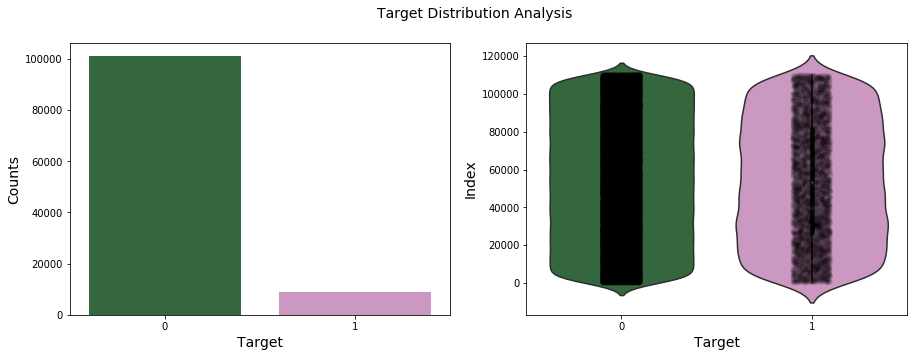

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(train.TARGET.mean(), 4)}")

sns.countplot(train.TARGET, ax=axes[0], palette="cubehelix")
sns.violinplot(train.TARGET, train.index, ax=axes[1], palette="cubehelix")
sns.stripplot(train.TARGET, train.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

Мы имеем достаточно большой дисбаланс классов, но целевая переменная распределена достаточно равномерно вдоль индексов тренировочного датасета

# validation

Попробуем применить KFold валидацию на 5 фолдов

In [55]:
import time

In [49]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [50]:
target, test_id = train["TARGET"], test["APPLICATION_NUMBER"]
train = train.drop(["APPLICATION_NUMBER", "TARGET"], axis=1)
test = test.drop(["APPLICATION_NUMBER"], axis=1)

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

# model

In [51]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(2)

Categorical Feature Count 4


,NAME_CONTRACT_TYPE,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
0,Cash,M,Secondary / secondary special,Married
1,Cash,NaN,NaN,NaN


In [52]:
categorical_features_list = categorical_features.columns.tolist()

In [53]:
train[categorical_features_list] = train[categorical_features_list].astype(str)
test[categorical_features_list] = test[categorical_features_list].astype(str)

In [56]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

estimators, oof_preds = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cv, categorical=categorical_features_list
)

Sun Sep 27 16:08:31 2020, Cross-Validation, 110093 rows, 336 cols
0:	test: 0.6532578	test1: 0.6548149	best: 0.6548149 (0)	total: 195ms	remaining: 6m 30s
10:	test: 0.6903685	test1: 0.6816567	best: 0.6816567 (10)	total: 912ms	remaining: 2m 44s
20:	test: 0.6937657	test1: 0.6834441	best: 0.6839784 (18)	total: 1.63s	remaining: 2m 33s
30:	test: 0.6992590	test1: 0.6903007	best: 0.6903007 (30)	total: 2.31s	remaining: 2m 26s
40:	test: 0.7007804	test1: 0.6931917	best: 0.6931917 (40)	total: 3s	remaining: 2m 23s
50:	test: 0.7018474	test1: 0.6938836	best: 0.6942131 (45)	total: 3.65s	remaining: 2m 19s
60:	test: 0.7025843	test1: 0.6940443	best: 0.6942304 (51)	total: 4.34s	remaining: 2m 18s
70:	test: 0.7026403	test1: 0.6947639	best: 0.6947639 (70)	total: 5.47s	remaining: 2m 28s
80:	test: 0.7035815	test1: 0.6953831	best: 0.6953831 (80)	total: 6.75s	remaining: 2m 39s
90:	test: 0.7036144	test1: 0.6949597	best: 0.6961426 (83)	total: 7.9s	remaining: 2m 45s
100:	test: 0.7044639	test1: 0.6959813	best: 0.6961

130:	test: 0.7070768	test1: 0.7025600	best: 0.7029846 (127)	total: 13.3s	remaining: 3m 10s
140:	test: 0.7071783	test1: 0.7023320	best: 0.7029846 (127)	total: 14.4s	remaining: 3m 9s
150:	test: 0.7076959	test1: 0.7028414	best: 0.7029846 (127)	total: 15.4s	remaining: 3m 8s
160:	test: 0.7081675	test1: 0.7032529	best: 0.7032750 (159)	total: 16.4s	remaining: 3m 7s
170:	test: 0.7092407	test1: 0.7044355	best: 0.7044632 (169)	total: 17.5s	remaining: 3m 6s
180:	test: 0.7104810	test1: 0.7054088	best: 0.7054088 (180)	total: 18.5s	remaining: 3m 6s
190:	test: 0.7114868	test1: 0.7061110	best: 0.7061110 (190)	total: 19.6s	remaining: 3m 5s
200:	test: 0.7121086	test1: 0.7065989	best: 0.7065989 (200)	total: 20.6s	remaining: 3m 4s
210:	test: 0.7127867	test1: 0.7072976	best: 0.7072976 (210)	total: 21.7s	remaining: 3m 3s
220:	test: 0.7134054	test1: 0.7079881	best: 0.7079910 (219)	total: 22.8s	remaining: 3m 3s
230:	test: 0.7141501	test1: 0.7087167	best: 0.7087167 (230)	total: 23.8s	remaining: 3m 2s
240:	test

1030:	test: 0.7425712	test1: 0.7227757	best: 0.7227757 (1030)	total: 1m 45s	remaining: 1m 39s
1040:	test: 0.7427968	test1: 0.7228061	best: 0.7228061 (1040)	total: 1m 46s	remaining: 1m 38s
1050:	test: 0.7430213	test1: 0.7228967	best: 0.7228967 (1050)	total: 1m 47s	remaining: 1m 36s
1060:	test: 0.7433388	test1: 0.7229881	best: 0.7229881 (1060)	total: 1m 48s	remaining: 1m 35s
1070:	test: 0.7435843	test1: 0.7231159	best: 0.7231159 (1070)	total: 1m 49s	remaining: 1m 34s
1080:	test: 0.7438040	test1: 0.7231489	best: 0.7231489 (1080)	total: 1m 50s	remaining: 1m 33s
1090:	test: 0.7440450	test1: 0.7231660	best: 0.7231886 (1084)	total: 1m 51s	remaining: 1m 32s
1100:	test: 0.7441095	test1: 0.7231576	best: 0.7231886 (1084)	total: 1m 52s	remaining: 1m 31s
1110:	test: 0.7442849	test1: 0.7232332	best: 0.7232332 (1110)	total: 1m 53s	remaining: 1m 30s
1120:	test: 0.7445177	test1: 0.7232090	best: 0.7232332 (1110)	total: 1m 54s	remaining: 1m 29s
1130:	test: 0.7447689	test1: 0.7232916	best: 0.7232931 (1129

610:	test: 0.7329922	test1: 0.7257650	best: 0.7257650 (610)	total: 1m 3s	remaining: 2m 23s
620:	test: 0.7333269	test1: 0.7259442	best: 0.7259442 (620)	total: 1m 4s	remaining: 2m 22s
630:	test: 0.7335984	test1: 0.7260561	best: 0.7260581 (629)	total: 1m 5s	remaining: 2m 21s
640:	test: 0.7338374	test1: 0.7261198	best: 0.7261204 (638)	total: 1m 6s	remaining: 2m 20s
650:	test: 0.7341249	test1: 0.7261953	best: 0.7261953 (650)	total: 1m 7s	remaining: 2m 18s
660:	test: 0.7343523	test1: 0.7262019	best: 0.7262284 (653)	total: 1m 7s	remaining: 2m 17s
670:	test: 0.7346398	test1: 0.7263640	best: 0.7263640 (670)	total: 1m 8s	remaining: 2m 16s
680:	test: 0.7347780	test1: 0.7264434	best: 0.7264475 (679)	total: 1m 9s	remaining: 2m 15s
690:	test: 0.7350373	test1: 0.7264085	best: 0.7265059 (683)	total: 1m 10s	remaining: 2m 14s
700:	test: 0.7354162	test1: 0.7265618	best: 0.7266018 (699)	total: 1m 11s	remaining: 2m 13s
710:	test: 0.7356461	test1: 0.7265003	best: 0.7266018 (699)	total: 1m 12s	remaining: 2m 

450:	test: 0.7308783	test1: 0.7125629	best: 0.7125629 (450)	total: 47.2s	remaining: 2m 42s
460:	test: 0.7313162	test1: 0.7127049	best: 0.7127049 (460)	total: 48.2s	remaining: 2m 41s
470:	test: 0.7318109	test1: 0.7128896	best: 0.7128896 (470)	total: 49.3s	remaining: 2m 40s
480:	test: 0.7321055	test1: 0.7129478	best: 0.7129478 (480)	total: 50.4s	remaining: 2m 39s
490:	test: 0.7324161	test1: 0.7130465	best: 0.7130465 (490)	total: 51.4s	remaining: 2m 37s
500:	test: 0.7327788	test1: 0.7131283	best: 0.7131283 (500)	total: 52.4s	remaining: 2m 36s
510:	test: 0.7331786	test1: 0.7131695	best: 0.7132082 (505)	total: 53.4s	remaining: 2m 35s
520:	test: 0.7335988	test1: 0.7132847	best: 0.7132847 (520)	total: 54.5s	remaining: 2m 34s
530:	test: 0.7339743	test1: 0.7133806	best: 0.7133806 (530)	total: 55.5s	remaining: 2m 33s
540:	test: 0.7344032	test1: 0.7136325	best: 0.7136325 (540)	total: 56.5s	remaining: 2m 32s
550:	test: 0.7346273	test1: 0.7136929	best: 0.7137030 (546)	total: 57.5s	remaining: 2m 31s

70:	test: 0.7025756	test1: 0.6936177	best: 0.6936177 (70)	total: 7.02s	remaining: 3m 10s
80:	test: 0.7041523	test1: 0.6951230	best: 0.6951230 (80)	total: 8.06s	remaining: 3m 10s
90:	test: 0.7058939	test1: 0.6970833	best: 0.6970836 (89)	total: 9.14s	remaining: 3m 11s
100:	test: 0.7069176	test1: 0.6979270	best: 0.6981442 (97)	total: 10.2s	remaining: 3m 11s
110:	test: 0.7073813	test1: 0.6978878	best: 0.6981442 (97)	total: 11.2s	remaining: 3m 11s
120:	test: 0.7077755	test1: 0.6981961	best: 0.6981961 (120)	total: 12.3s	remaining: 3m 10s
130:	test: 0.7080015	test1: 0.6986466	best: 0.6987699 (129)	total: 13.4s	remaining: 3m 10s
140:	test: 0.7082257	test1: 0.6988924	best: 0.6989537 (139)	total: 14.4s	remaining: 3m 9s
150:	test: 0.7085519	test1: 0.6991586	best: 0.6993384 (148)	total: 15.5s	remaining: 3m 9s
160:	test: 0.7087828	test1: 0.6991419	best: 0.6993384 (148)	total: 16.5s	remaining: 3m 8s
170:	test: 0.7090272	test1: 0.6994783	best: 0.6994783 (170)	total: 17.6s	remaining: 3m 8s
180:	test: 

980:	test: 0.7432575	test1: 0.7200840	best: 0.7200840 (980)	total: 1m 39s	remaining: 1m 43s
990:	test: 0.7434833	test1: 0.7201253	best: 0.7201395 (985)	total: 1m 40s	remaining: 1m 42s
1000:	test: 0.7435891	test1: 0.7200992	best: 0.7201395 (985)	total: 1m 41s	remaining: 1m 41s
1010:	test: 0.7437307	test1: 0.7201331	best: 0.7201395 (985)	total: 1m 42s	remaining: 1m 40s
1020:	test: 0.7438548	test1: 0.7201062	best: 0.7201395 (985)	total: 1m 43s	remaining: 1m 39s
1030:	test: 0.7440270	test1: 0.7201501	best: 0.7201612 (1029)	total: 1m 44s	remaining: 1m 38s
1040:	test: 0.7442453	test1: 0.7202284	best: 0.7202284 (1040)	total: 1m 45s	remaining: 1m 37s
1050:	test: 0.7443572	test1: 0.7202624	best: 0.7202630 (1049)	total: 1m 46s	remaining: 1m 36s
1060:	test: 0.7445411	test1: 0.7202264	best: 0.7202691 (1052)	total: 1m 47s	remaining: 1m 35s
1070:	test: 0.7446567	test1: 0.7202530	best: 0.7202691 (1052)	total: 1m 48s	remaining: 1m 34s
1080:	test: 0.7448392	test1: 0.7202934	best: 0.7202934 (1080)	total

In [57]:
oof_score = roc_auc_score(
    target, oof_preds
)
print(f"OOF-score = {round(oof_score, 5)}")

OOF-score = 0.7214


In [68]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict_proba(x_valid)[:, 1]
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict_proba(x_valid_copy)[:, 1]
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [69]:
perm_importance = calculate_permutation_importance(
    estimator=estimators[0], metric=roc_auc_score, x_valid=train, y_valid=target
)

100%|██████████| 336/336 [01:52<00:00,  3.00it/s]


In [87]:
features_to_drop = list(perm_importance.tail(40).index)

In [88]:
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

In [89]:
categorial = train.dtypes[train.dtypes == "object"].index

In [90]:
estimators, oof_preds = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cv, categorical=categorial
)

Sun Sep 27 16:48:18 2020, Cross-Validation, 110093 rows, 296 cols
0:	test: 0.5309436	test1: 0.5175126	best: 0.5175126 (0)	total: 74.3ms	remaining: 2m 28s
10:	test: 0.6900994	test1: 0.6785448	best: 0.6785448 (10)	total: 799ms	remaining: 2m 24s
20:	test: 0.6924291	test1: 0.6782068	best: 0.6803108 (19)	total: 1.51s	remaining: 2m 22s
30:	test: 0.6955651	test1: 0.6833526	best: 0.6851784 (27)	total: 2.25s	remaining: 2m 22s
40:	test: 0.7001437	test1: 0.6883305	best: 0.6885766 (34)	total: 2.94s	remaining: 2m 20s
50:	test: 0.7006438	test1: 0.6883362	best: 0.6885766 (34)	total: 3.63s	remaining: 2m 18s
60:	test: 0.7017599	test1: 0.6909744	best: 0.6909744 (60)	total: 4.29s	remaining: 2m 16s
70:	test: 0.7028106	test1: 0.6913245	best: 0.6914290 (69)	total: 4.99s	remaining: 2m 15s
80:	test: 0.7039913	test1: 0.6923449	best: 0.6923449 (80)	total: 5.87s	remaining: 2m 19s
90:	test: 0.7043994	test1: 0.6931303	best: 0.6931303 (90)	total: 7.08s	remaining: 2m 28s
100:	test: 0.7054696	test1: 0.6944049	best: 0

900:	test: 0.7431904	test1: 0.7190561	best: 0.7190562 (891)	total: 1m 26s	remaining: 1m 45s
910:	test: 0.7434615	test1: 0.7190385	best: 0.7190861 (906)	total: 1m 27s	remaining: 1m 44s
920:	test: 0.7437973	test1: 0.7190526	best: 0.7190861 (906)	total: 1m 28s	remaining: 1m 43s
930:	test: 0.7440233	test1: 0.7190625	best: 0.7190861 (906)	total: 1m 28s	remaining: 1m 42s
940:	test: 0.7442247	test1: 0.7191195	best: 0.7191195 (940)	total: 1m 29s	remaining: 1m 41s
950:	test: 0.7443431	test1: 0.7190502	best: 0.7191196 (941)	total: 1m 30s	remaining: 1m 40s
960:	test: 0.7445876	test1: 0.7190545	best: 0.7191196 (941)	total: 1m 31s	remaining: 1m 39s
970:	test: 0.7448670	test1: 0.7190259	best: 0.7191196 (941)	total: 1m 32s	remaining: 1m 38s
980:	test: 0.7450426	test1: 0.7190148	best: 0.7191196 (941)	total: 1m 33s	remaining: 1m 37s
990:	test: 0.7452321	test1: 0.7190680	best: 0.7191196 (941)	total: 1m 34s	remaining: 1m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.719119649
be

790:	test: 0.7387197	test1: 0.7220471	best: 0.7220683 (787)	total: 1m 16s	remaining: 1m 56s
800:	test: 0.7389564	test1: 0.7220986	best: 0.7220994 (798)	total: 1m 17s	remaining: 1m 55s
810:	test: 0.7392861	test1: 0.7222374	best: 0.7222374 (810)	total: 1m 18s	remaining: 1m 54s
820:	test: 0.7395155	test1: 0.7222458	best: 0.7223054 (814)	total: 1m 19s	remaining: 1m 53s
830:	test: 0.7397910	test1: 0.7223244	best: 0.7223303 (829)	total: 1m 20s	remaining: 1m 52s
840:	test: 0.7400345	test1: 0.7223530	best: 0.7223564 (835)	total: 1m 20s	remaining: 1m 51s
850:	test: 0.7401928	test1: 0.7224693	best: 0.7224693 (850)	total: 1m 21s	remaining: 1m 50s
860:	test: 0.7404730	test1: 0.7225781	best: 0.7225924 (858)	total: 1m 22s	remaining: 1m 49s
870:	test: 0.7406962	test1: 0.7226180	best: 0.7226287 (866)	total: 1m 23s	remaining: 1m 48s
880:	test: 0.7408878	test1: 0.7226569	best: 0.7226617 (879)	total: 1m 24s	remaining: 1m 47s
890:	test: 0.7410827	test1: 0.7227253	best: 0.7227308 (887)	total: 1m 25s	remain

610:	test: 0.7342749	test1: 0.7262043	best: 0.7262043 (610)	total: 59.8s	remaining: 2m 15s
620:	test: 0.7345054	test1: 0.7263392	best: 0.7263392 (620)	total: 1m	remaining: 2m 14s
630:	test: 0.7347434	test1: 0.7263097	best: 0.7263442 (621)	total: 1m 1s	remaining: 2m 13s
640:	test: 0.7350021	test1: 0.7263051	best: 0.7263442 (621)	total: 1m 2s	remaining: 2m 12s
650:	test: 0.7352484	test1: 0.7263798	best: 0.7263798 (650)	total: 1m 3s	remaining: 2m 11s
660:	test: 0.7354801	test1: 0.7264313	best: 0.7264541 (658)	total: 1m 4s	remaining: 2m 10s
670:	test: 0.7358073	test1: 0.7264847	best: 0.7264847 (670)	total: 1m 5s	remaining: 2m 9s
680:	test: 0.7359965	test1: 0.7265340	best: 0.7265509 (678)	total: 1m 6s	remaining: 2m 8s
690:	test: 0.7363354	test1: 0.7265945	best: 0.7265945 (690)	total: 1m 7s	remaining: 2m 7s
700:	test: 0.7365622	test1: 0.7266241	best: 0.7266287 (699)	total: 1m 8s	remaining: 2m 6s
710:	test: 0.7368639	test1: 0.7267894	best: 0.7267894 (710)	total: 1m 9s	remaining: 2m 5s
720:	te

110:	test: 0.7088486	test1: 0.6995371	best: 0.6995371 (110)	total: 10.6s	remaining: 2m 59s
120:	test: 0.7092470	test1: 0.6998577	best: 0.7000658 (119)	total: 11.5s	remaining: 2m 58s
130:	test: 0.7097026	test1: 0.6997708	best: 0.7000658 (119)	total: 12.5s	remaining: 2m 58s
140:	test: 0.7099392	test1: 0.6998627	best: 0.7000658 (119)	total: 13.4s	remaining: 2m 57s
150:	test: 0.7103450	test1: 0.7001723	best: 0.7002261 (148)	total: 14.4s	remaining: 2m 56s
160:	test: 0.7107118	test1: 0.7003710	best: 0.7003710 (160)	total: 15.4s	remaining: 2m 56s
170:	test: 0.7109329	test1: 0.7006038	best: 0.7006336 (166)	total: 16.4s	remaining: 2m 55s
180:	test: 0.7115106	test1: 0.7012469	best: 0.7012469 (180)	total: 17.4s	remaining: 2m 55s
190:	test: 0.7123015	test1: 0.7022195	best: 0.7022195 (190)	total: 18.4s	remaining: 2m 54s
200:	test: 0.7137534	test1: 0.7031658	best: 0.7031658 (200)	total: 19.4s	remaining: 2m 53s
210:	test: 0.7152630	test1: 0.7039649	best: 0.7039649 (210)	total: 20.3s	remaining: 2m 52s

1010:	test: 0.7459241	test1: 0.7154364	best: 0.7154418 (988)	total: 1m 36s	remaining: 1m 34s
1020:	test: 0.7460986	test1: 0.7154307	best: 0.7154443 (1015)	total: 1m 37s	remaining: 1m 33s
1030:	test: 0.7462914	test1: 0.7154602	best: 0.7154810 (1028)	total: 1m 37s	remaining: 1m 32s
1040:	test: 0.7465285	test1: 0.7154964	best: 0.7154996 (1039)	total: 1m 38s	remaining: 1m 31s
1050:	test: 0.7467015	test1: 0.7154999	best: 0.7155026 (1045)	total: 1m 39s	remaining: 1m 30s
1060:	test: 0.7468112	test1: 0.7155564	best: 0.7155564 (1060)	total: 1m 40s	remaining: 1m 28s
1070:	test: 0.7470433	test1: 0.7156394	best: 0.7156394 (1070)	total: 1m 41s	remaining: 1m 27s
1080:	test: 0.7471939	test1: 0.7157006	best: 0.7157006 (1080)	total: 1m 42s	remaining: 1m 26s
1090:	test: 0.7473301	test1: 0.7157374	best: 0.7157385 (1089)	total: 1m 43s	remaining: 1m 25s
1100:	test: 0.7474540	test1: 0.7157590	best: 0.7157597 (1098)	total: 1m 44s	remaining: 1m 24s
1110:	test: 0.7475385	test1: 0.7157902	best: 0.7157952 (1102)

1900:	test: 0.7572819	test1: 0.7179245	best: 0.7179245 (1900)	total: 2m 53s	remaining: 9.03s
1910:	test: 0.7574608	test1: 0.7179740	best: 0.7179740 (1910)	total: 2m 54s	remaining: 8.12s
1920:	test: 0.7576000	test1: 0.7179815	best: 0.7179890 (1911)	total: 2m 55s	remaining: 7.21s
1930:	test: 0.7577420	test1: 0.7180092	best: 0.7180092 (1930)	total: 2m 56s	remaining: 6.29s
1940:	test: 0.7579693	test1: 0.7180252	best: 0.7180321 (1936)	total: 2m 57s	remaining: 5.38s
1950:	test: 0.7581471	test1: 0.7180702	best: 0.7180702 (1950)	total: 2m 57s	remaining: 4.47s
1960:	test: 0.7583251	test1: 0.7180385	best: 0.7180702 (1950)	total: 2m 58s	remaining: 3.56s
1970:	test: 0.7584558	test1: 0.7180442	best: 0.7180702 (1950)	total: 2m 59s	remaining: 2.64s
1980:	test: 0.7585666	test1: 0.7180602	best: 0.7180702 (1950)	total: 3m	remaining: 1.73s
1990:	test: 0.7587198	test1: 0.7180447	best: 0.7180702 (1950)	total: 3m 1s	remaining: 820ms
1999:	test: 0.7588529	test1: 0.7180401	best: 0.7180702 (1950)	total: 3m 2s	

790:	test: 0.7398195	test1: 0.7189043	best: 0.7189201 (785)	total: 1m 16s	remaining: 1m 56s
800:	test: 0.7401447	test1: 0.7189270	best: 0.7189410 (792)	total: 1m 17s	remaining: 1m 55s
810:	test: 0.7402900	test1: 0.7189172	best: 0.7189410 (792)	total: 1m 18s	remaining: 1m 54s
820:	test: 0.7405435	test1: 0.7189636	best: 0.7189636 (820)	total: 1m 19s	remaining: 1m 53s
830:	test: 0.7407222	test1: 0.7190131	best: 0.7190147 (829)	total: 1m 20s	remaining: 1m 52s
840:	test: 0.7409518	test1: 0.7190552	best: 0.7190636 (837)	total: 1m 21s	remaining: 1m 51s
850:	test: 0.7411633	test1: 0.7190944	best: 0.7190976 (847)	total: 1m 22s	remaining: 1m 50s
860:	test: 0.7413999	test1: 0.7191363	best: 0.7191507 (859)	total: 1m 22s	remaining: 1m 49s
870:	test: 0.7417282	test1: 0.7191740	best: 0.7191783 (869)	total: 1m 23s	remaining: 1m 48s
880:	test: 0.7419787	test1: 0.7193114	best: 0.7193114 (880)	total: 1m 24s	remaining: 1m 47s
890:	test: 0.7420634	test1: 0.7193312	best: 0.7193420 (884)	total: 1m 25s	remain

In [91]:
oof_score = roc_auc_score(
    target, oof_preds
)
print(f"OOF-score = {round(oof_score, 5)}")

OOF-score = 0.72166


# predict test data

In [92]:
y_pred = np.zeros(test.shape[0])
# test[numerical] = test[numerical].astype(float)
test[categorical_features_list] = test[categorical_features_list].astype(str)

for estimator in estimators:
    y_pred += estimator.predict_proba(test)[:, 1]

In [93]:
predictions = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred / cv.n_splits
})
predictions.to_csv("./ASirotkin.csv", index=False)